In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def reReadData():
  df=pd.read_csv('gdrive/My Drive/master_ds_v2_NoNA.csv',header=0, index_col=0, 
                infer_datetime_format=True, parse_dates=['Date'])
  df = df.dropna()
  df = df[train_start:test_end]
  df_train, df_test = df[train_start:train_end],df[train_end:test_end]
  return df, df_train, df_test


def plotProb_train(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_train.index, df_train['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_train.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def plotProb_test(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_test.index, df_test['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_test.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def labeling(model,threshold1, threshold2):
  bear_regime = 0 if model.params['const[0]'] < model.params['const[1]'] else 1

  label_filtered = []
  
  for i in model.filtered_marginal_probabilities[bear_regime].values:
    if i >= threshold1:
      app = -1
    elif i >= threshold2:
      app = 0
    else:
      app = 1
    label_filtered.append(app)

  label_filtered= np.array(label_filtered)
  
  return label_filtered


def duration(label):

  duration_bull = []
  duration_static = []
  duration_bear = []

  count,prev = 1,1

  for i in label:
    if i == prev:
      count+=1
    else:
      if prev == 1:
        duration_bull.append(count)
        count = 1
      elif prev == 0:
        duration_static.append(count)
        count = 1
      else:
        duration_bear.append(count)
        count = 1
    prev = i
    
  if prev == 1:
    duration_bull.append(count)
  elif prev == 0:
    duration_static.append(count)
  else:
    duration_bear.append(count)

  duration_bull = pd.DataFrame(duration_bull)
  duration_static = pd.DataFrame(duration_static)
  duration_bear = pd.DataFrame(duration_bear)

  return duration_bull, duration_static, duration_bear


def label_train_logret(label):
  return (df_train['log_ret'] * label).sum()

def label_test_logret(label):
  return (df_test['log_ret'] * label).sum()



def Search_train(model, duration_static, duration_bear):
  threshold1, threshold2, record =0,0,0
  for i in range(1,101):
    for j in range(i):
      label_filtered = labeling(model,i/100, j/100)
      if ( (duration(label_filtered))[1].mean().values >= duration_static ):
        if ( (duration(label_filtered))[2].mean().values >= duration_bear ) :
          if ( (df_train['log_ret'] * label_filtered).sum() >= record ):
            threshold1, threshold2, record = i,j,(df_train['log_ret'] * label_filtered).sum()
  return threshold1/100, threshold2/100



In [4]:
duration_static, duration_bear = 2.5, 4

## Set time period

In [5]:
train_start = '2010-01-01'
train_end = '2017-12-31'
test_end = '2020-12-31'

## Read data

In [6]:
df,df_train,df_test = reReadData()
print(df,df_train,df_test)

            Russell_Close  ...  hmm1 smoothed state
Date                       ...                     
2010-06-28        2821.11  ...                   -1
2010-06-29        2729.76  ...                   -1
2010-06-30        2703.08  ...                   -1
2010-07-01        2692.74  ...                   -1
2010-07-02        2678.58  ...                   -1
...                   ...  ...                  ...
2020-12-24       12137.42  ...                    1
2020-12-28       12203.97  ...                    1
2020-12-29       12155.89  ...                    1
2020-12-30       12189.07  ...                    1
2020-12-31       12248.16  ...                    1

[2643 rows x 248 columns]             Russell_Close  ...  hmm1 smoothed state
Date                       ...                     
2010-06-28        2821.11  ...                   -1
2010-06-29        2729.76  ...                   -1
2010-06-30        2703.08  ...                   -1
2010-07-01        2692.74  ...       

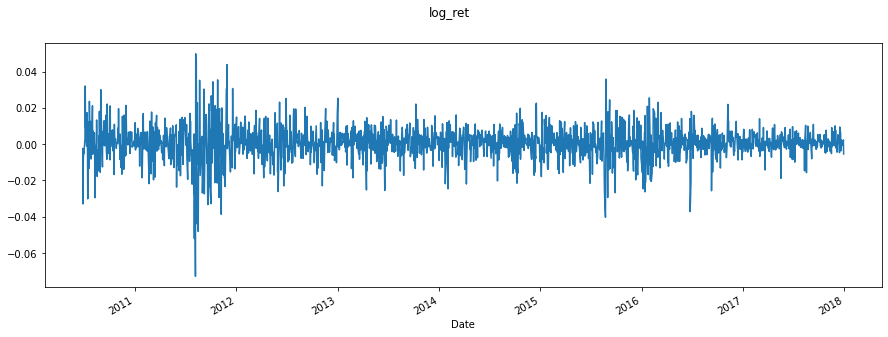

In [7]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('log_ret')
df_train['log_ret'].plot()
plt.show()

In [8]:
k = 15
df = df.rolling(k).mean()
df = df.dropna()
df = df[train_start:test_end]
df_train, df_test = df[train_start:train_end],df[train_end:test_end]
df

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,POS_RET,POS_SR,State_RET_shifted,State_SR_shifted,Ret_Russell_Close,Ret_1MTBill,Ret_3MTBill,...,lag80_Ret_3M_USD_LIBOR,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,hmm1 smoothed state
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-19,2782.037333,1.534979e+09,0.147933,0.162800,0.207533,0.292667,0.998200,1.790733,2.995267,3.975133,2.856667,2.392000,0.528235,0.367333,0.170000,75.386667,75.417333,0.066667,42.066667,0.066667,-0.086667,0.066667,9.553333,0.0,3.0,-0.053333,-0.214667,-0.230667,0.001,121.419167,-0.399740,1062.325333,4.647318e+09,0.866667,0.933333,-0.266667,0.466667,0.000753,-0.038435,-0.009162,...,0.264609,81.439333,81.410667,1153.071333,4.561845e+09,2813.282667,0.051600,0.104667,0.182867,0.336400,1.387733,2.349000,3.687067,4.631267,3.594667,2.840000,0.250493,76.207333,76.236000,1086.273333,4.484525e+09,2921.572667,0.022533,0.057933,0.147467,0.333267,1.477533,2.473333,3.717667,4.612467,3.684000,2.809333,0.250180,79.196000,79.082667,1130.610667,4.718121e+09,-0.000631,-0.466667,-1.0
2010-07-20,2783.028000,1.551868e+09,0.153867,0.164000,0.207200,0.291467,0.992267,1.779533,2.987600,3.971533,2.852667,2.388000,0.526839,0.366667,0.170667,75.332667,75.337333,0.066667,-3.200000,0.066667,-0.080000,0.066667,9.540000,0.0,3.0,0.044000,-0.169333,-0.175333,0.001,121.264427,-0.578047,1062.919333,4.701776e+09,1.000000,1.000000,-0.200000,0.600000,-0.000223,-0.031905,-0.005356,...,0.266983,81.460667,81.381333,1155.922000,4.676771e+09,2815.280667,0.054333,0.105667,0.183400,0.335733,1.385400,2.346000,3.685200,4.630467,3.586667,2.838000,0.250685,76.286667,76.318667,1086.650667,4.500237e+09,2915.170667,0.020000,0.057733,0.145600,0.326667,1.463267,2.455667,3.705667,4.606667,3.676000,2.809333,0.249930,78.656000,78.568000,1128.009333,4.906661e+09,0.000350,-0.600000,-1.0
2010-07-21,2787.605333,1.519225e+09,0.160600,0.164667,0.205867,0.290067,0.987733,1.771667,2.984267,3.970133,2.847333,2.385333,0.525055,0.364667,0.172667,75.374000,75.405333,0.066667,-48.466667,0.066667,-0.073333,0.066667,9.526667,0.0,3.0,0.172667,-0.152000,-0.118667,0.001,121.275887,-0.780667,1064.809333,4.609141e+09,1.000000,1.000000,-0.133333,0.733333,-0.001559,-0.038206,-0.001847,...,0.269325,81.360667,81.271333,1157.781333,4.715132e+09,2823.476667,0.057867,0.107733,0.184600,0.336467,1.386733,2.345267,3.684267,4.629200,3.583333,2.836667,0.250881,76.721333,76.760667,1089.409333,4.372603e+09,2906.175333,0.019667,0.058600,0.144267,0.320733,1.452733,2.444067,3.695867,4.601267,3.663333,2.807333,0.249847,78.020000,77.944000,1124.502000,4.938643e+09,0.001656,-0.600000,-1.0
2010-07-22,2798.423333,1.503903e+09,0.159600,0.162800,0.203867,0.285133,0.981400,1.762200,2.980867,3.969267,2.848000,2.385333,0.522647,0.364000,0.178667,75.618667,75.664000,0.066667,-93.733333,0.066667,-0.066667,0.06

## Three regimes, common variance

In [9]:
hmm0 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=3,trend='c')
hmm0_results = hmm0.fit(search_reps = 100)
print(hmm0_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1478: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1478: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1478: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have bee

                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 1821
Model:               MarkovRegression   Log Likelihood                9466.444
Date:                Sun, 06 Feb 2022   AIC                         -18912.888
Time:                        02:12:56   BIC                         -18857.816
Sample:                             0   HQIC                        -18892.571
                               - 1821                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002   6.17e-05     -3.615      0.000      -0.000      -0.000
                             Regime 1 parameters    

Note that the transition prob. from bear to static and from bull to static are too high.

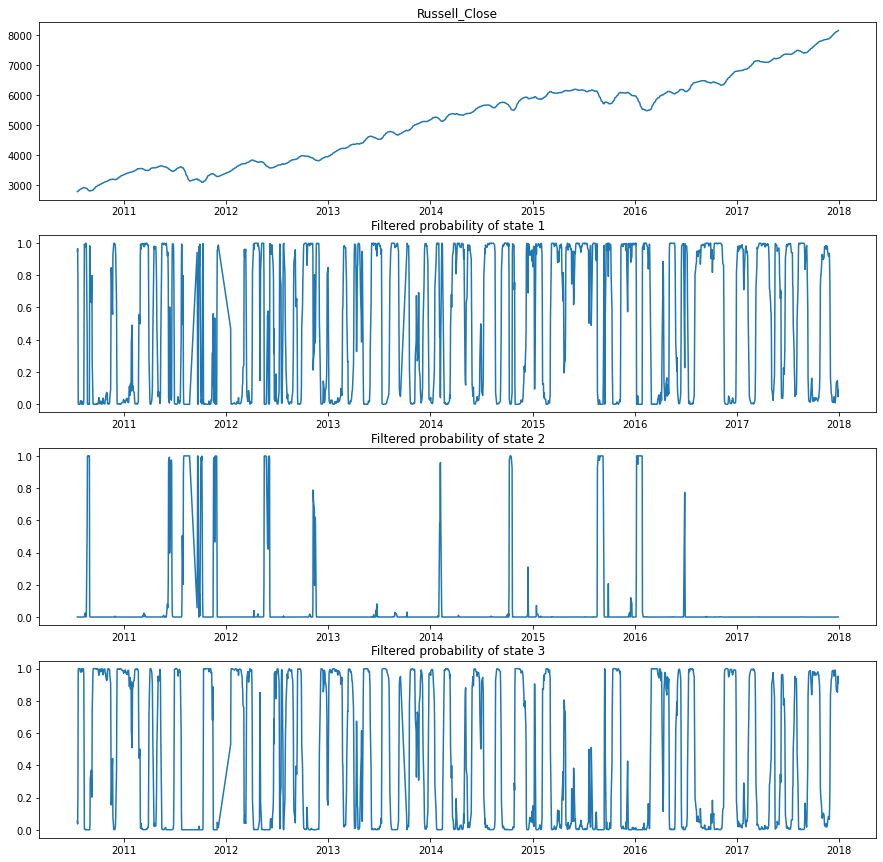

In [10]:
fig, axes = plt.subplots(4, figsize=(15, 15))

ax = axes[0]
ax.plot(df_train.index, df_train['Russell_Close'])
ax.set(title='Russell_Close')
 
ax = axes[1]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[0])
ax.set(title='Filtered probability of state 1')
 
ax = axes[2]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[1])
ax.set(title='Filtered probability of state 2')

ax = axes[3]
ax.plot(df_train.index, hmm0_results.filtered_marginal_probabilities[2])
ax.set(title='Filtered probability of state 3')

plt.show()


## Two regimes, switching mean and variance

In [11]:
hmm1 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_results = hmm1.fit(search_reps = 100)
print(hmm1_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 1821
Model:               MarkovRegression   Log Likelihood                9190.983
Date:                Sun, 06 Feb 2022   AIC                         -18369.965
Time:                        02:12:59   BIC                         -18336.923
Sample:                             0   HQIC                        -18357.775
                               - 1821                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015   4.39e-05     35.265      0.000       0.001       0.002
sigma2      1.558e-06   1.27e-07     12.276      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


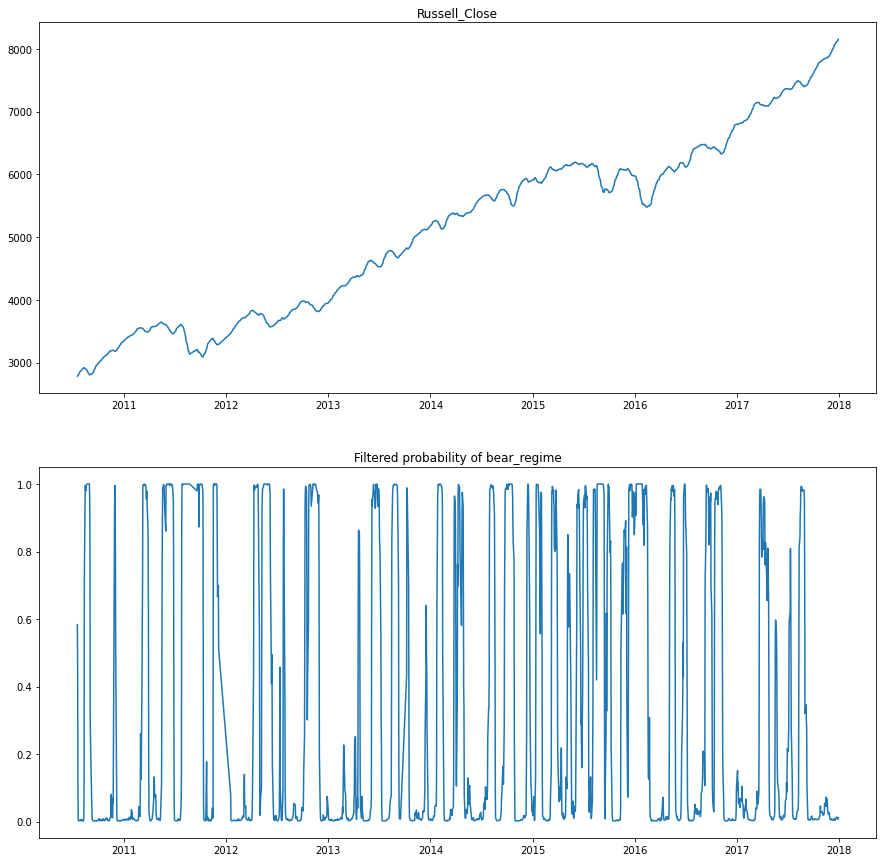

In [12]:
plotProb_train(hmm1_results)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


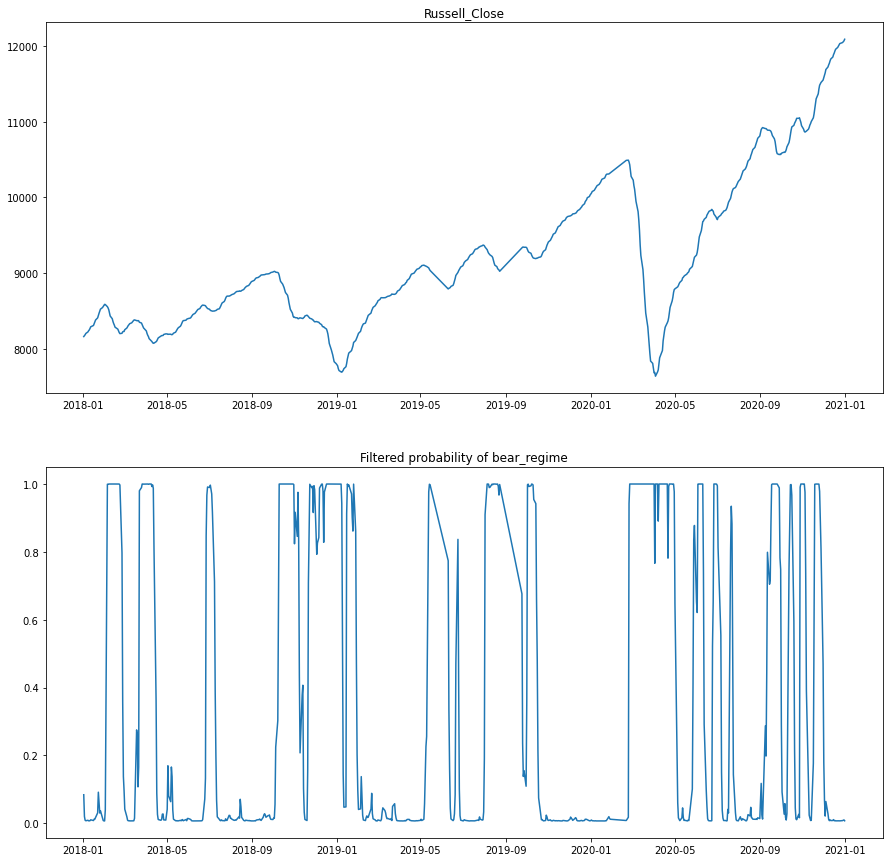

In [13]:
#using the same probability filter constructed from the training set
hmm1_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)
plotProb_test(hmm1_test_results)

In [14]:
t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.83 0.19


In [15]:
label_filtered = labeling(hmm1_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    24.06383
dtype: float64
0    2.561798
dtype: float64
0    10.288889
dtype: float64
0.9741441635200531 2.715926954760753


In [16]:
np.histogram(label_filtered)

(array([ 463,    0,    0,    0,    0,  228,    0,    0,    0, 1130]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

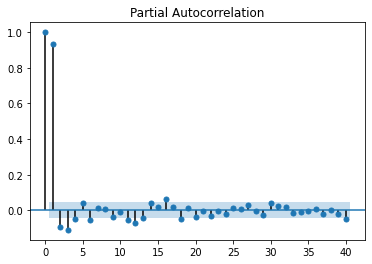

In [17]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()

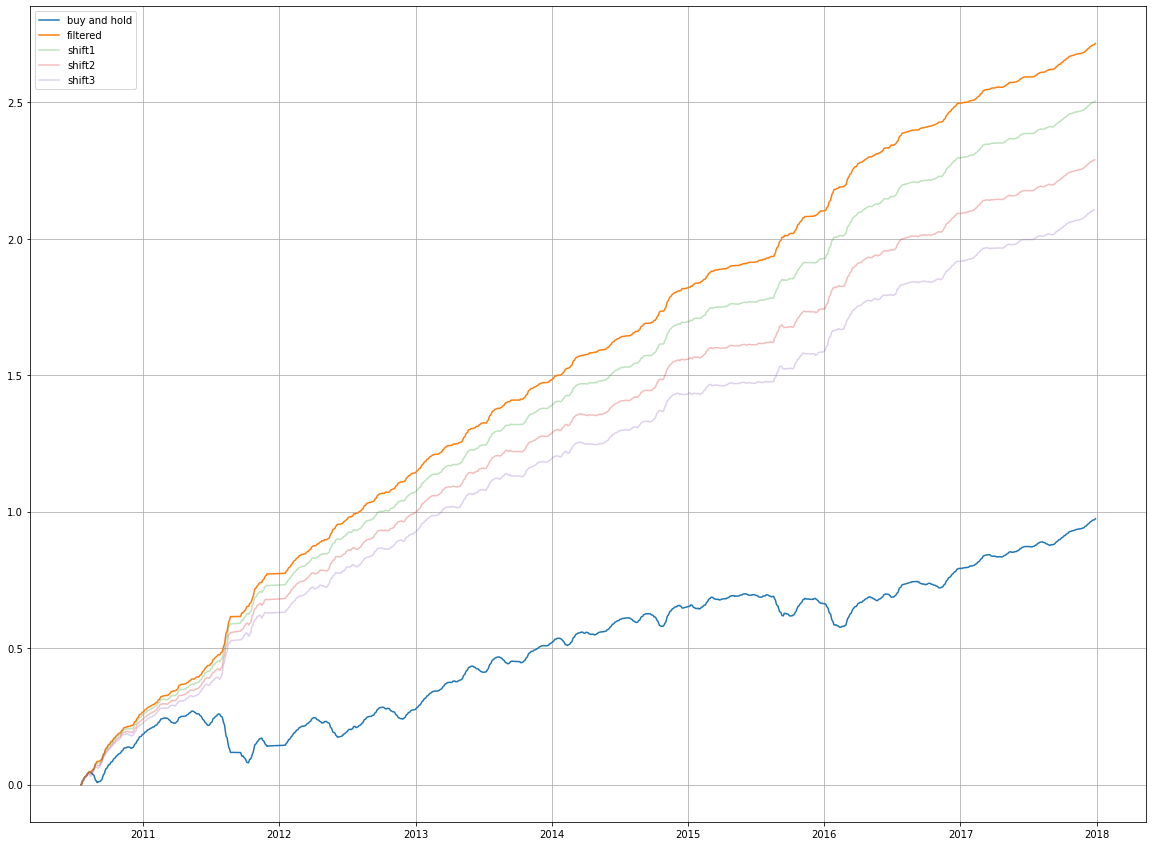

In [18]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [19]:
label_filtered = labeling(hmm1_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    21.65
dtype: float64
0    1.864865
dtype: float64
0    8.5
dtype: float64
0.37538340662051406 1.0792176545218632


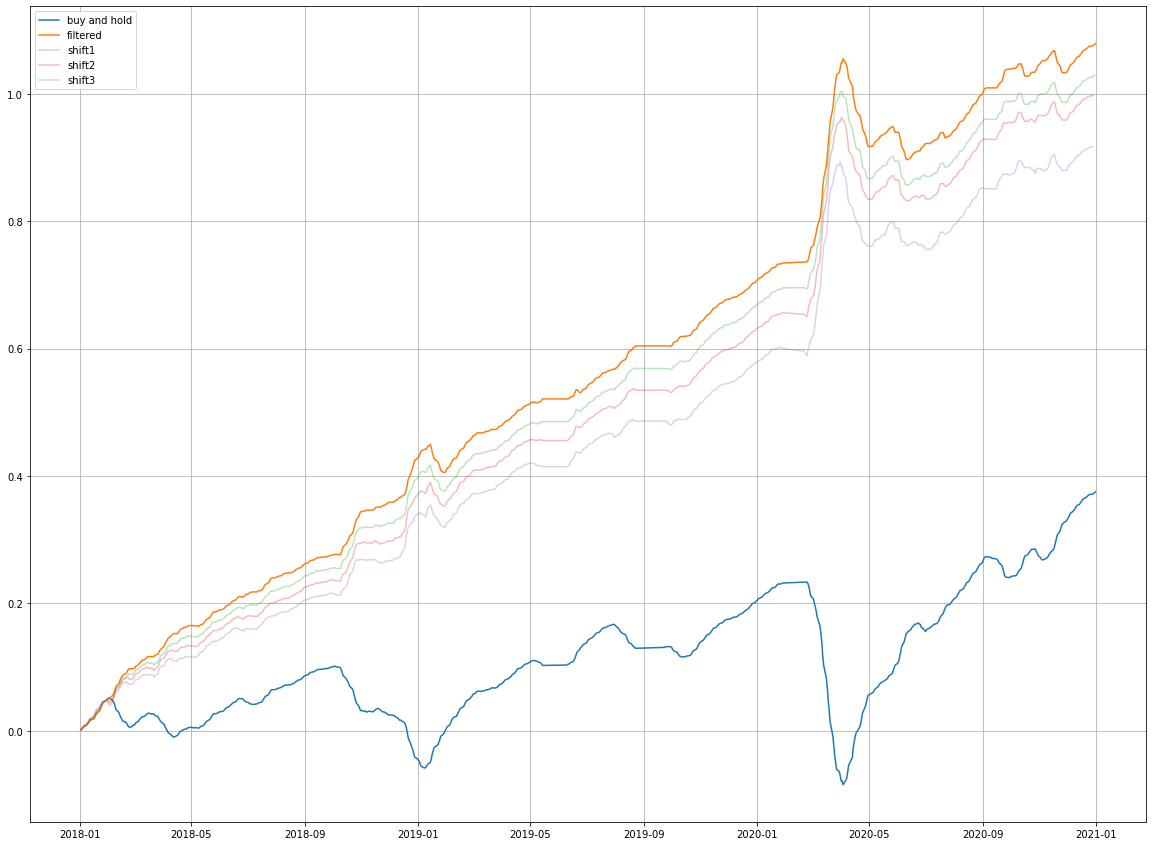

In [20]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables in transition prob.

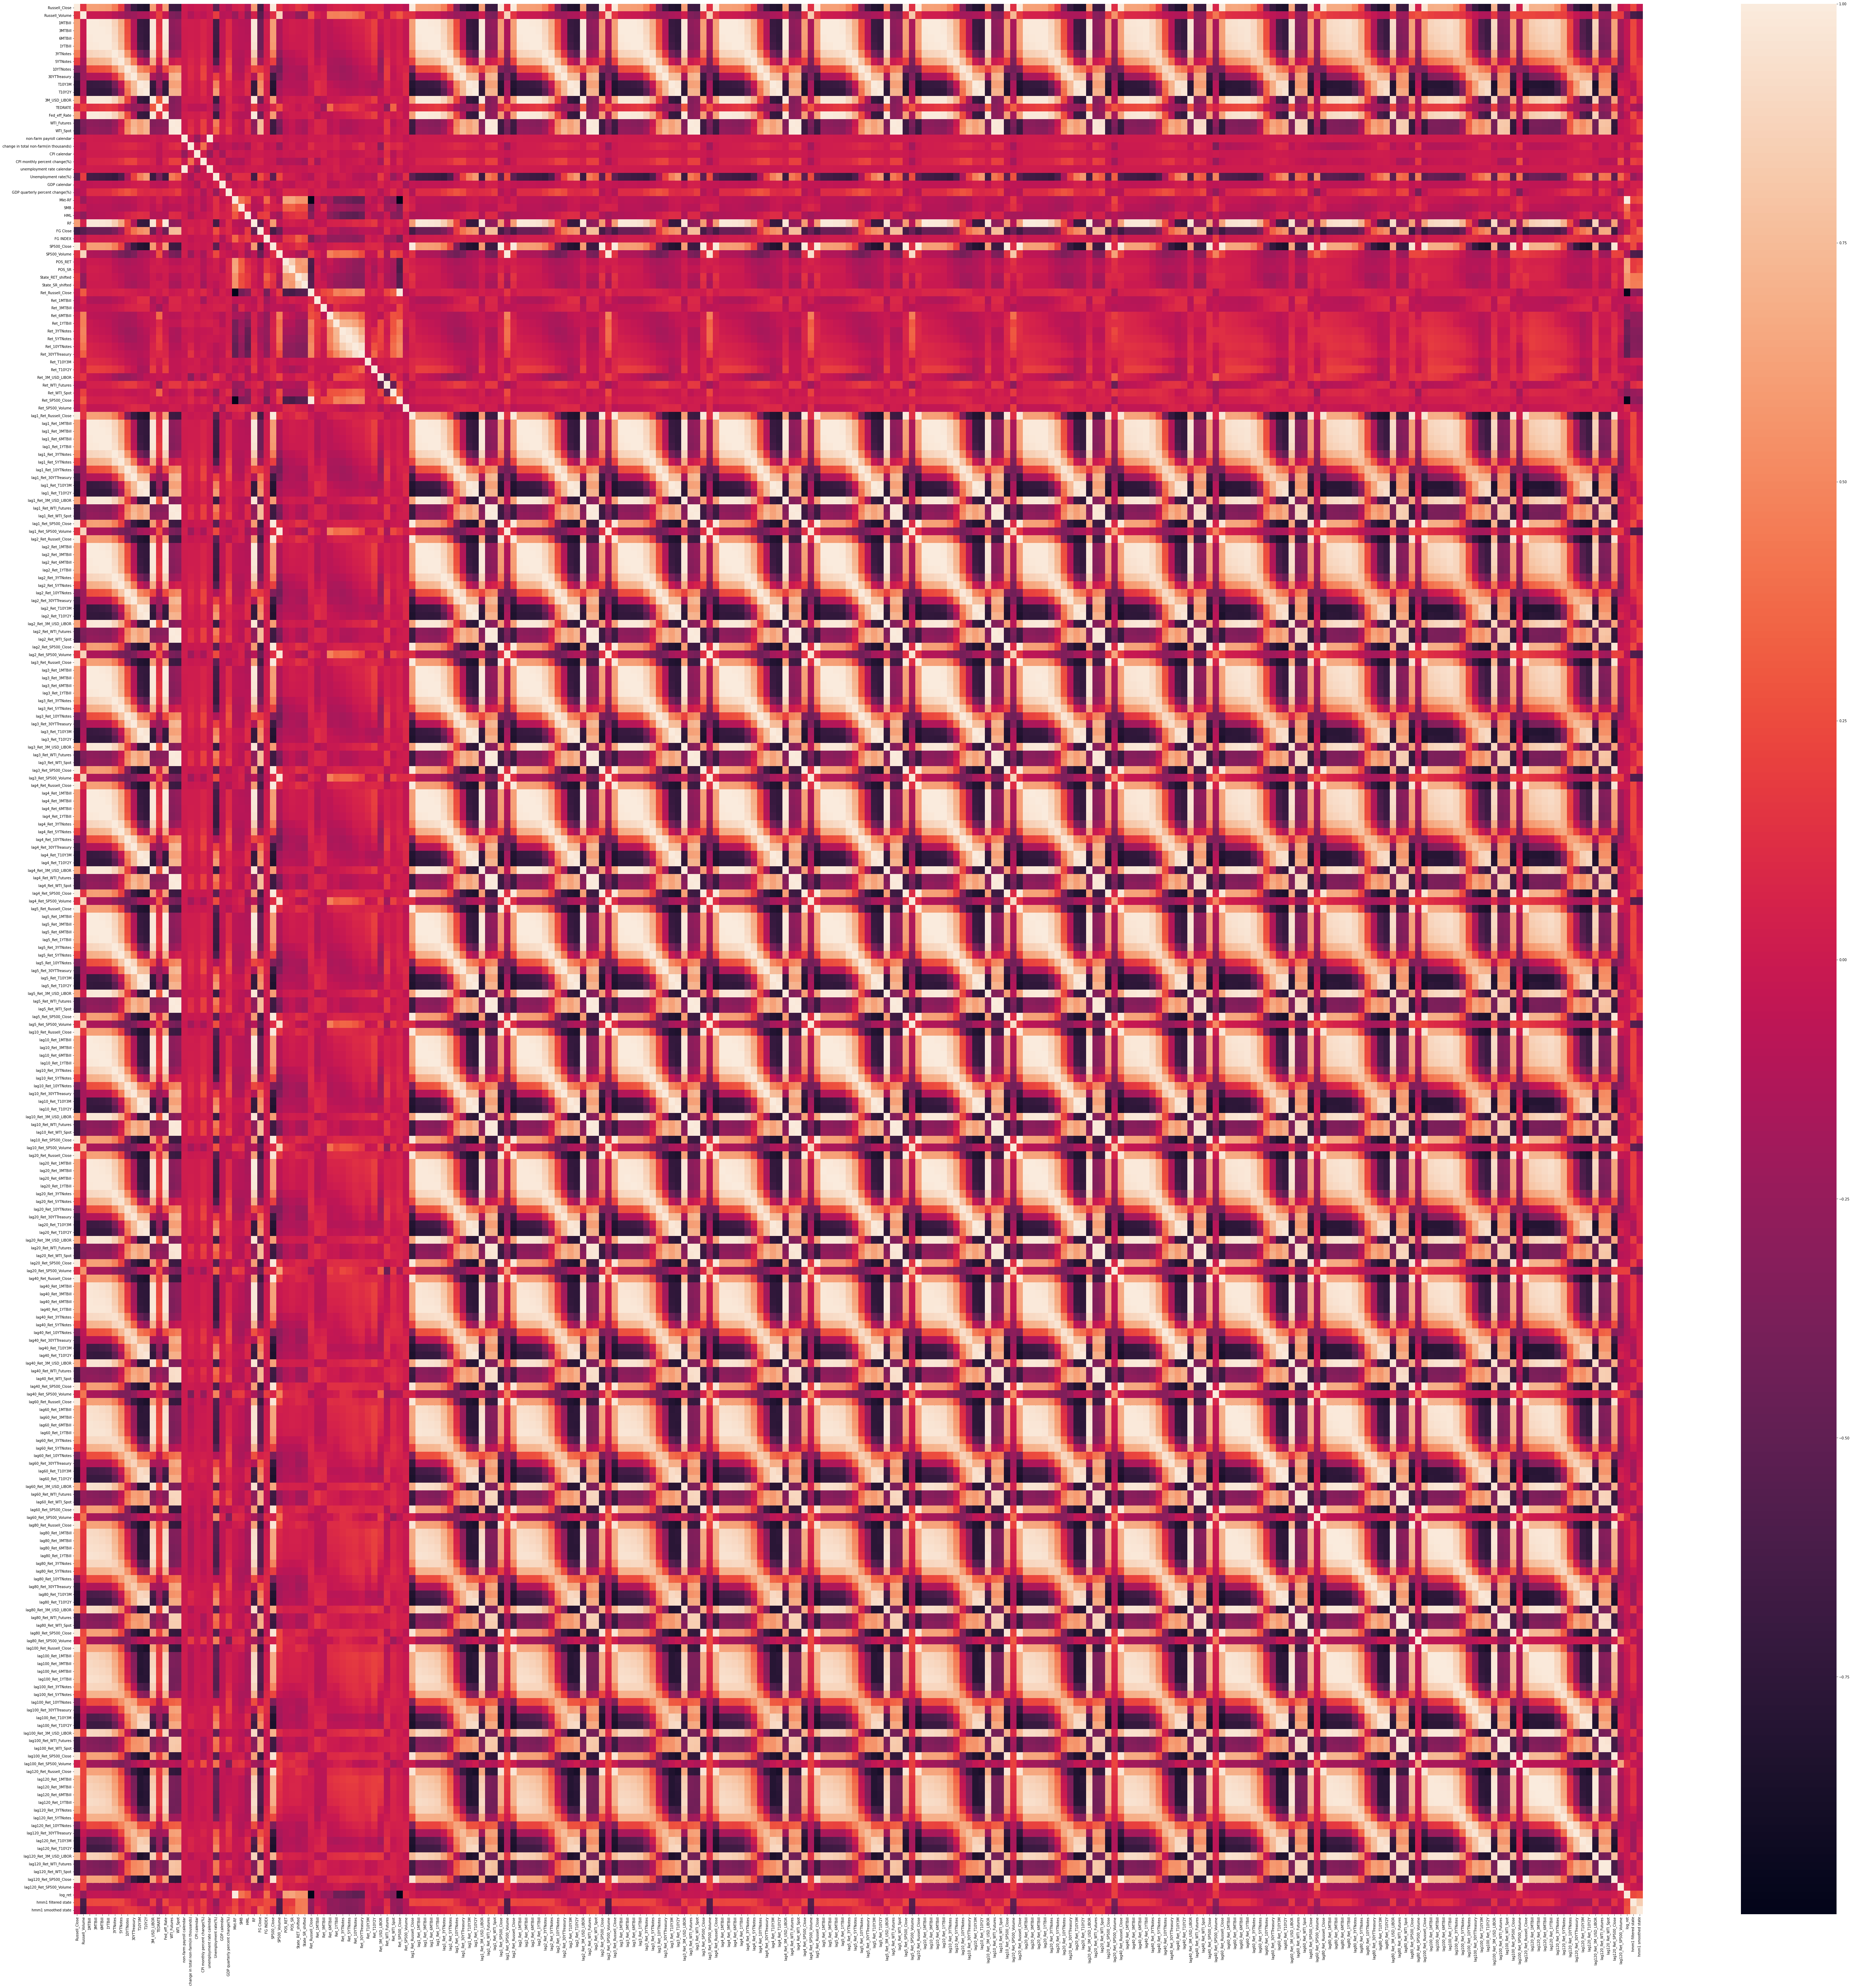

In [21]:
import seaborn as sns
%matplotlib inline

Var_Corr = df.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(100,100)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [22]:
for i,j in zip (df[df.columns.to_list()].apply(lambda x: x.autocorr()) , df.columns):
  print(j,i)

Russell_Close 0.9999529551326211
Russell_Volume 0.9865394838262
1MTBill 0.9999377376438485
3MTBill 0.9999506276497915
6MTBill 0.9999531385073878
1YTBill 0.9999513647174085
3YTNotes 0.9998658458547591
5YTNotes 0.9997673296057149
10YTNotes 0.9997360136107066
30YTTreasury 0.9998034020418877
T10Y3M 0.9998601542008011
T10Y2Y 0.9999271321721815
3M_USD_LIBOR 0.999957812067592
TEDRATE 0.998452302586275
Fed_eff_Rate 0.9999404871733437
WTI_Futures 0.9998337762906621
WTI_Spot 0.9998587109736392
non-farm payroll calendar 0.7646801861705651
change in total non-farm(in thousands) 0.99542730915567
CPI calendar 0.7726180028236725
CPI monthly percent change(%) 0.9974487126325647
unemployment rate calendar 0.7646801861705651
Unemployment rate(%) 0.9996628989512857
GDP calendar 0.8862868091030589
GDP quarterly percent change(%) 0.9983494356744242
Mkt-RF 0.9103043268819333
SMB 0.9265406864129084
HML 0.92008300507728
RF 0.9997993102443046
FG Close 0.9996990109669603
FG INDEX 0.9903355102760718
SP500_Close 

In [23]:
# dependent variables used for transition prob.
# hmm1 smoothed state is not measurable; others contain nan

df_train_tvtp = df_train.drop( columns= ['hmm1 smoothed state','Ret_1MTBill','Ret_T10Y3M', 'Ret_T10Y2Y'])
df_train_tvtp = df_train_tvtp.dropna()

mean,std = df_train_tvtp.mean(),df_train_tvtp.std()

df_train_tvtp = (df_train_tvtp-df_train_tvtp.mean())/df_train_tvtp.std()
df_train_tvtp['ones'] = 1
df_train_tvtp

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,POS_RET,POS_SR,State_RET_shifted,State_SR_shifted,Ret_Russell_Close,Ret_3MTBill,Ret_6MTBill,...,lag80_Ret_3M_USD_LIBOR,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-19,-1.713289,2.533034,-0.128423,-0.175257,-0.250599,-0.237877,0.309783,0.890100,1.496533,1.388898,1.339863,1.254513,0.082478,0.806853,-0.349550,0.035762,0.037652,0.628664,-1.681685,0.631188,-1.190707,0.628664,1.643586,-0.916743,0.850285,-0.542261,-1.680248,-1.922466,0.314152,-1.942962,-0.062970,-1.772798,2.176887,0.839613,1.280219,-1.111254,-0.094714,0.601717,-0.185920,-0.187828,...,-0.681721,0.240817,0.240101,-1.443820,1.389515,-1.561185,-0.431072,-0.261600,-0.205970,0.056666,1.479955,2.066743,2.477559,2.249253,2.343592,1.897933,-0.727408,0.010008,0.011666,-1.574449,1.214652,-1.452443,-0.594097,-0.469584,-0.329127,0.088042,1.740597,2.284188,2.442121,2.156350,2.421484,1.813306,-0.724927,0.123889,0.119617,-1.434674,1.536194,-0.568632,-1.607169,1
2010-07-20,-1.712579,2.630035,-0.107012,-0.171406,-0.251577,-0.241134,0.294276,0.863349,1.480423,1.382532,1.333018,1.247625,0.078445,0.800415,-0.347385,0.033519,0.034328,0.628664,-2.205284,0.631188,-1.156082,0.628664,1.635977,-0.916743,0.850285,-0.066485,-1.324645,-1.454025,0.314152,-1.950335,-0.103959,-1.771368,2.296175,1.062246,1.389071,-0.990240,0.122782,0.131000,-0.164891,-0.052317,...,-0.673444,0.241716,0.238864,-1.436756,1.582854,-1.559697,-0.416566,-0.257045,-0.203813,0.054224,1.473446,2.060028,2.474135,2.247940,2.330320,1.894427,-0.726704,0.013387,0.015188,-1.573512,1.240797,-1.457241,-0.609172,-0.470596,-0.337286,0.062280,1.700756,2.245571,2.420747,2.146995,2.408393,1.813306,-0.725895,0.100726,0.097537,-1.441167,1.846103,-0.090120,-1.826970,1
2010-07-21,-1.709300,2.442549,-0.082713,-0.169267,-0.255486,-0.244933,0.282428,0.844559,1.473418,1.380056,1.323892,1.243033,0.073293,0.781103,-0.340890,0.035236,0.037153,0.628664,-2.728883,0.631188,-1.121456,0.628664,1.628368,-0.916743,0.850285,0.562453,-1.188679,-0.974297,0.314152,-1.949789,-0.150536,-1.766818,2.093263,1.062246,1.389071,-0.869226,0.340278,-0.513582,-0.145507,0.163819,...,-0.665282,0.237501,0.234226,-1.432149,1.647389,-1.553594,-0.397813,-0.247632,-0.198962,0.056910,1.477166,2.058386,2.472423,2.245860,2.324790,1.892089,-0.725986,0.031901,0.034016,-1.566662,1.028414,-1.463983,-0.611155,-0.466211,-0.343114,0.039119,1.671341,2.220215,2.403292,2.138286,2.387666,1.809802,-0.726217,0.073445,0.070766,-1.449922,1.898674,0.547001,-1.826970,1
2010-07-22,-1.701549,2.354551,-0.086321,-0.175257,-0.261350,-0.258320,0.265876,0.821948,1.466274,1.378524,1.325033,1.243033,0.066334,0.774666,-0.321403,0.045400,0.047898,0.628664,-3.252482,0.631188,-1.086831,0.628664,1.620759,-0.916743,0.850285,1.654132,-0.561145,-0.449417,0.314152,-1

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df_train_tvtp)
principalDf_train = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_train

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,-8.733743,13.655549,0.185821,11.203826,0.496587
1,-8.684918,13.490938,-0.111817,11.405986,-0.422350
2,-8.634170,13.324581,-0.446789,11.434319,-1.587076
3,-8.598682,13.147105,-0.868390,11.511232,-2.992725
4,-8.538489,12.971706,-1.198912,11.366486,-4.334751
...,...,...,...,...,...
1816,31.109789,8.797451,-7.860818,-2.698757,0.900131
1817,31.216586,8.916063,-7.974194,-2.852381,0.792710
1818,31.329118,8.996368,-8.029530,-3.061124,0.835210
1819,31.455421,9.018433,-8.184679,-3.334994,0.380373


In [25]:
pca.explained_variance_ratio_.sum()

0.837531738541259

In [26]:
hmm2 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c', exog_tvtp = principalDf_train,
                                    switching_variance=True)
hmm2_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 1821
Model:               MarkovRegression   Log Likelihood                9219.888
Date:                Sun, 06 Feb 2022   AIC                         -18411.775
Time:                        02:13:45   BIC                         -18334.675
Sample:                             0   HQIC                        -18383.331
                               - 1821                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009   6.84e-05    -13.362      0.000      -0.001      -0.001
sigma2      3.435e-06   2.44e-07     14.075      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


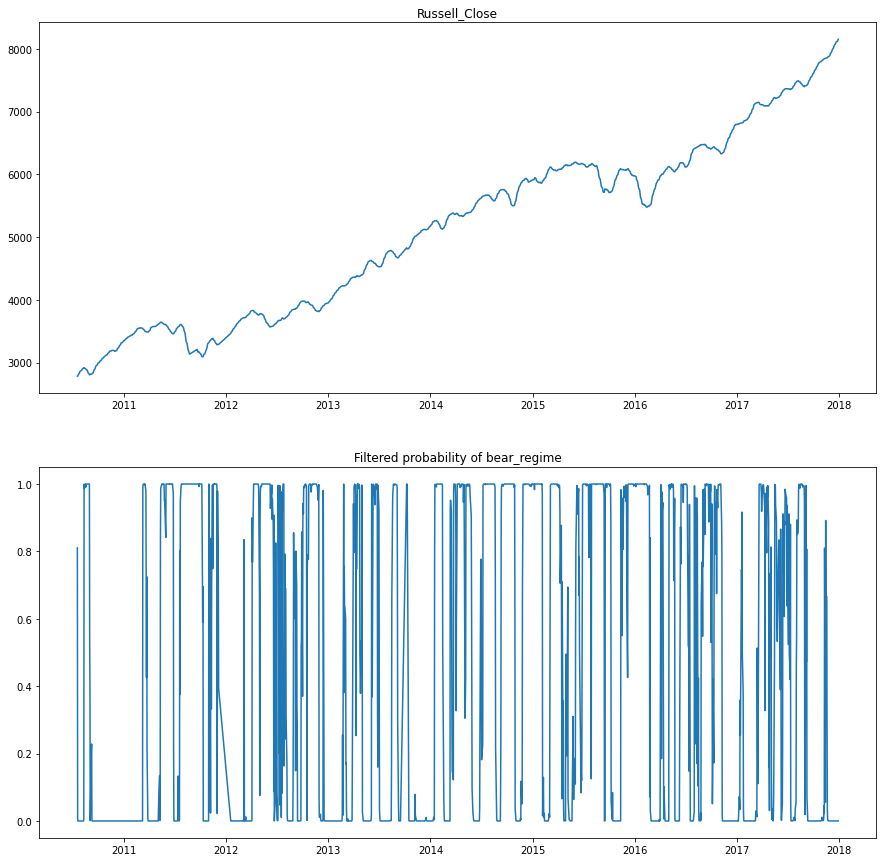

In [27]:
plotProb_train(hmm2_results)

In [28]:
pd.options.mode.use_inf_as_na = True
df_test.columns[df_test.isna().any()].tolist()

[]

In [29]:
df_test_tvtp = df_test.drop( columns= ['hmm1 smoothed state','Ret_1MTBill','Ret_T10Y3M', 'Ret_T10Y2Y'])
df_test_tvtp = df_test_tvtp.dropna()

df_test_tvtp = (df_test_tvtp-mean)/std
df_test_tvtp['ones'] = 1

df_test_tvtp

,Russell_Close,Russell_Volume,1MTBill,3MTBill,6MTBill,1YTBill,3YTNotes,5YTNotes,10YTNotes,30YTTreasury,T10Y3M,T10Y2Y,3M_USD_LIBOR,TEDRATE,Fed_eff_Rate,WTI_Futures,WTI_Spot,non-farm payroll calendar,change in total non-farm(in thousands),CPI calendar,CPI monthly percent change(%),unemployment rate calendar,Unemployment rate(%),GDP calendar,GDP quarterly percent change(%),Mkt-RF,SMB,HML,RF,FG Close,FG INDEX,SP500_Close,SP500_Volume,POS_RET,POS_SR,State_RET_shifted,State_SR_shifted,Ret_Russell_Close,Ret_3MTBill,Ret_6MTBill,...,lag80_Ret_3M_USD_LIBOR,lag80_Ret_WTI_Futures,lag80_Ret_WTI_Spot,lag80_Ret_SP500_Close,lag80_Ret_SP500_Volume,lag100_Ret_Russell_Close,lag100_Ret_1MTBill,lag100_Ret_3MTBill,lag100_Ret_6MTBill,lag100_Ret_1YTBill,lag100_Ret_3YTNotes,lag100_Ret_5YTNotes,lag100_Ret_10YTNotes,lag100_Ret_30YTTreasury,lag100_Ret_T10Y3M,lag100_Ret_T10Y2Y,lag100_Ret_3M_USD_LIBOR,lag100_Ret_WTI_Futures,lag100_Ret_WTI_Spot,lag100_Ret_SP500_Close,lag100_Ret_SP500_Volume,lag120_Ret_Russell_Close,lag120_Ret_1MTBill,lag120_Ret_3MTBill,lag120_Ret_6MTBill,lag120_Ret_1YTBill,lag120_Ret_3YTNotes,lag120_Ret_5YTNotes,lag120_Ret_10YTNotes,lag120_Ret_30YTTreasury,lag120_Ret_T10Y3M,lag120_Ret_T10Y2Y,lag120_Ret_3M_USD_LIBOR,lag120_Ret_WTI_Futures,lag120_Ret_WTI_Spot,lag120_Ret_SP500_Close,lag120_Ret_SP500_Volume,log_ret,hmm1 filtered state,ones
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2.141610,-0.132990,3.692282,3.655101,3.560810,3.633314,2.853252,1.866043,0.298648,-0.726997,-1.747071,-1.909247,3.311628,0.208174,3.521850,-0.670329,-0.670194,-1.572868,0.098860,0.631188,0.609814,-1.572868,-1.468476,-0.916743,1.117219,0.314788,0.474286,-0.347828,2.972257,-0.738580,0.365815,2.114347,-1.068406,0.283029,1.389071,1.188009,0.77527,-0.328109,-0.169040,-0.392573,...,2.985946,-1.183721,-1.183403,1.769587,-1.274862,1.921516,4.552869,4.285695,3.666983,3.326830,1.814355,0.892344,-0.119237,-0.661295,-1.670146,-1.469549,3.162469,-1.163177,-1.162622,1.873558,-0.580994,1.869591,4.486697,4.385626,3.961333,3.556596,1.909830,0.942659,-0.131652,-0.731477,-1.557088,-1.530028,3.337032,-1.361554,-1.357675,1.807615,-0.654578,0.316620,0.810645,1
2018-01-03,2.149794,-0.114266,3.721633,3.674780,3.589545,3.656651,2.866668,1.879260,0.306773,-0.725936,-1.750493,-1.917283,3.337139,0.246799,3.578146,-0.660248,-0.659311,-1.572868,0.098860,0.631188,0.713690,-1.572868,-1.468476,-0.916743,1.117219,0.422327,0.495204,-0.359115,3.030042,-0.729236,0.376546,2.122865,-1.003172,0.394346,1.389071,1.188009,0.77527,-0.429285,-0.158239,-0.446116,...,2.984538,-1.182625,-1.181885,1.774778,-1.256932,1.915160,4.559237,4.254722,3.676146,3.324632,1.809334,0.885629,-0.126941,-0.667204,-1.666828,-1.473055,3.161641,-1.158066,-1.157709,1.867724,-0.532372,1.872392,4.523986,4.397768,3.963664,3.552953,1.921373,0.960000,-0.109922,-0.711263,-1.542906,-1.509008,3.340690,-1.351402,-1.347436,1.809648,-0.712344,0.419401,0.810645,1
2018-01-04,2.159131,-0.087114,3.731497,3.689968,3.612220,3.679988,2.881304,1.895183,0.313077,-0.724639,-1.751634,-1.925319,3.362232,0.285423,3.632276,-0.646760,-0.646821,-1.572868,0.098860,0.631188,0.817566,-1.572868,-1.468476,-0.916743,1.117219,0.536383,0.625940,-0.511500,3.087827,-0.714187,0.414518,2.132475,-0.982789,0.505663,1.389071,1.188009,0.77527,-0.522062,-0.152389,-0.384080,...,2.984991,-1.183861,-1.183600,1.785113,-1.270830,1.909659,4.563837,4.214335,3.685849,3.321457,1.799848,0.876974,-0.132687,-0.669503,-1.657980,-1.471887,3.161778,-1.149406,-1.148593,1.862555,-0.521239,1.876795,4.579522,4.422051,3.968909,3.546708,1.934405,0.975884,-0.087954,-0.689436,-1.531997,-1.489156,3.342768,-1.340536,-1.336367,1.813770,-0.792511,0.513473,0.810645,1
2018-01-05,2.171029,-0.126769,3.743767,3.712855,3.637437,3.704591,2.911446,1.923367,0.331848,-0.714972,-1.749352,-1.932207,3.384466,0.298298,3.686406,-0.633356,-0.633500,0.628664,0.085750,-1.583443,0.817566,0.628664,-1.468476,-0.916743,1.117219,0.744942,0.066389,-0.150292,3.145612,-0.68815

In [30]:
principalComponents = pca.transform(df_test_tvtp)
principalDf_test = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4','principal component 5'])
principalDf_test

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,31.664934,9.146286,-8.278655,-3.629005,0.534245
1,31.779233,9.226320,-8.372824,-3.752120,0.519015
2,31.897587,9.312042,-8.489541,-3.835402,0.339391
3,32.026749,9.348078,-8.638000,-4.024255,-0.174573
4,32.143623,9.422532,-8.760628,-4.112025,-0.432460
...,...,...,...,...,...
700,12.773551,-20.193161,10.249346,-1.742262,-2.573375
701,12.769479,-20.153355,10.428354,-1.943937,-1.633031
702,12.802200,-20.258606,10.352157,-2.308140,-2.233135
703,12.758536,-20.245980,10.259817,-2.650478,-1.900242


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


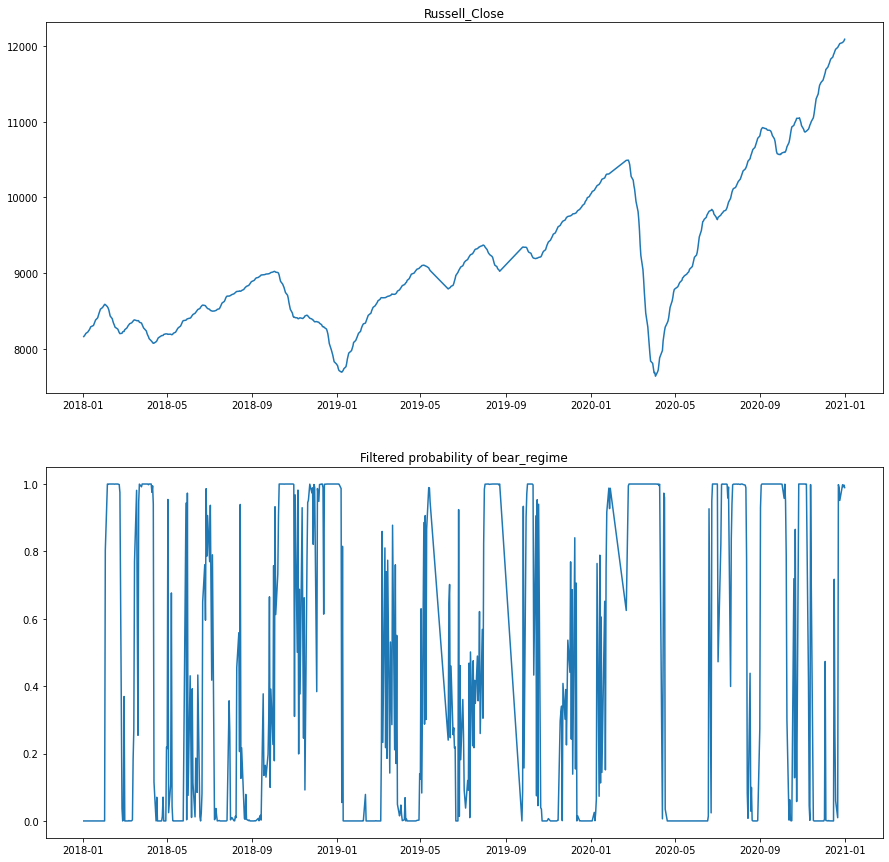

In [31]:
#using the same probability filter constructed from the training set
hmm2_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c',exog_tvtp = principalDf_test,
                                    switching_variance=True)
hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)
plotProb_test(hmm2_test_results)

In [32]:
t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.99 0.29


In [33]:
label_filtered = labeling(hmm2_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    12.157895
dtype: float64
0    2.51145
dtype: float64
0    7.38961
dtype: float64
0.9741441635200531 2.551037441132829


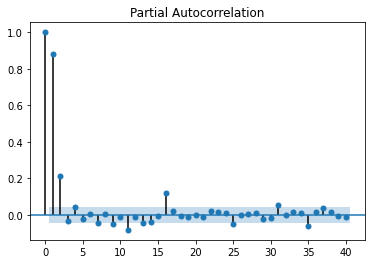

In [34]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()

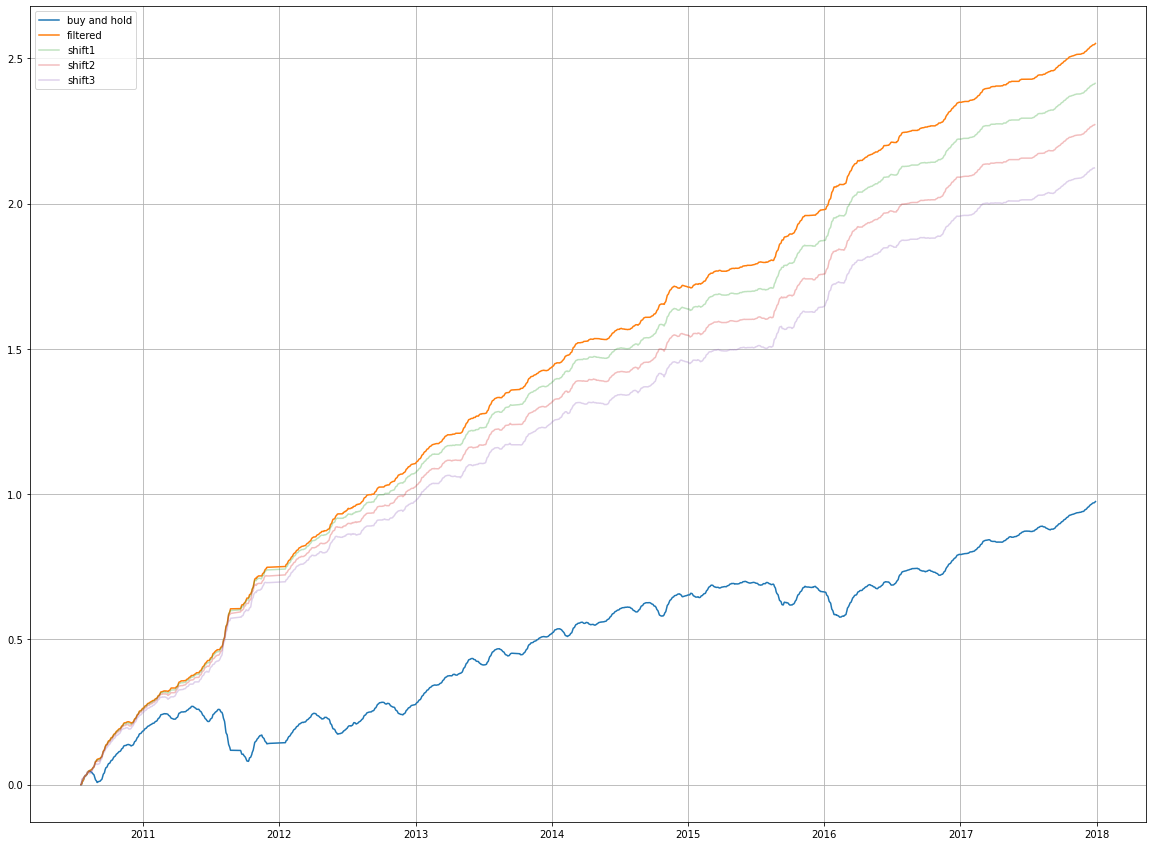

In [35]:
# training set plot

fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(df_train.index, np.abs(df_train['log_ret']).cumsum(),label="best")
ax.plot(df_train.index, df_train['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_train.index, (df_train['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_train.index, (df_train['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_train.index, (df_train['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

In [36]:
label_filtered = labeling(hmm2_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    5.111111
dtype: float64
0    1.761364
dtype: float64
0    8.714286
dtype: float64
0.37538340662051406 1.4002421444294244


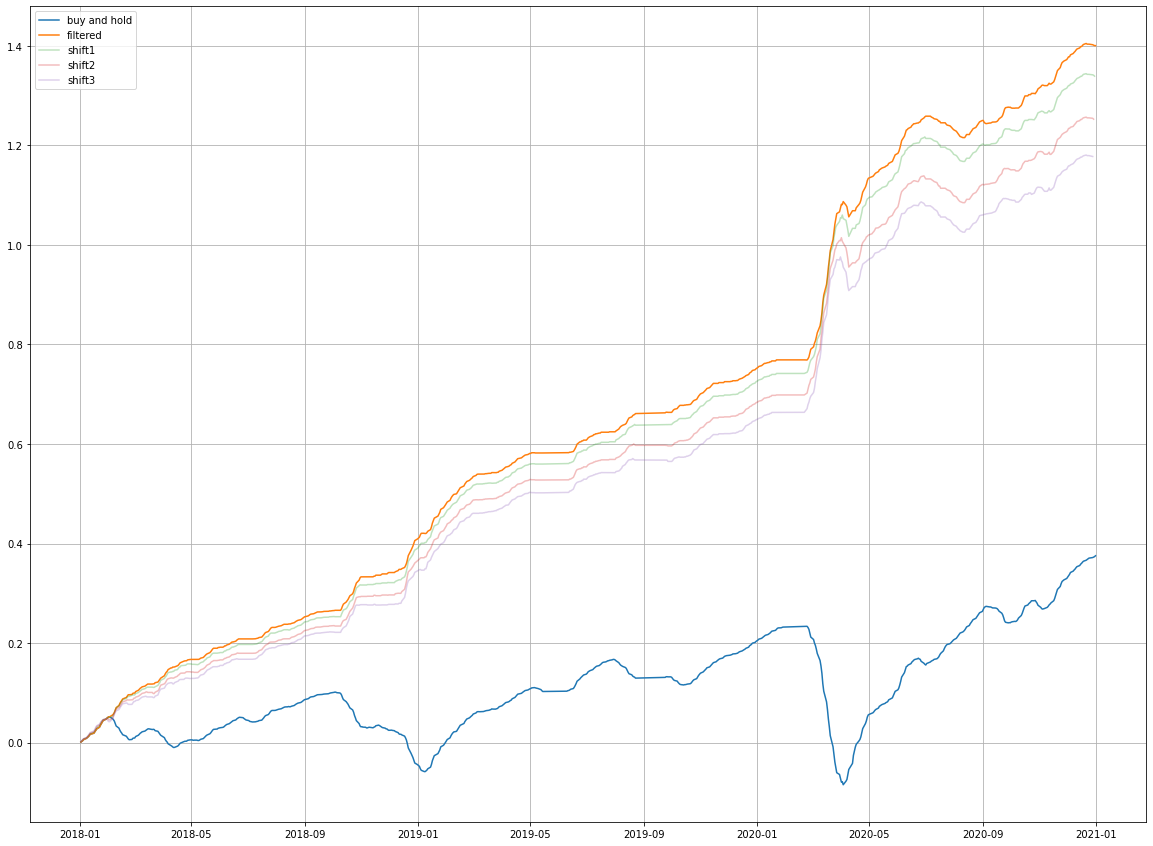

In [37]:
# testing set plot

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(df_test.index, df_test['log_ret'].cumsum(),label="buy and hold")
ax.plot(df_test.index, (df_test['log_ret'] * label_filtered).cumsum(),label = "filtered")
ax.plot(df_test.index, (df_test['log_ret'].shift(-1) * label_filtered).cumsum(),label = "shift1",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-2) * label_filtered).cumsum(),label = "shift2",alpha=0.3)
ax.plot(df_test.index, (df_test['log_ret'].shift(-3) * label_filtered).cumsum(),label = "shift3",alpha=0.3)
ax.grid(True)
ax.legend()

plt.show()

## Two regimes, switching mean and variance with other dependent variables in transition prob. and mean.

In [38]:
# switching mean dependent variabels
df_train_exog = df_train[['SMB','HML']]
df_test_exog = df_test[['SMB','HML']]

In [39]:
hmm3 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c', exog = df_train_exog, 
                               exog_tvtp = principalDf_train, switching_exog = True,switching_variance=True)
hmm3_results = hmm3.fit(search_reps = 100)
print(hmm3_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 1821
Model:               MarkovRegression   Log Likelihood                9305.553
Date:                Sun, 06 Feb 2022   AIC                         -18575.105
Time:                        02:14:12   BIC                         -18475.977
Sample:                             0   HQIC                        -18538.535
                               - 1821                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014   4.19e-05     34.074      0.000       0.001       0.002
x1             0.0051      0.000     19.662      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [40]:
t1,t2 = Search_train(hmm3_results, duration_static, duration_bear)
print(t1,t2)

0.98 0.32


In [41]:
label_filtered = labeling(hmm3_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    5.614943
dtype: float64
0    2.549296
dtype: float64
0    6.711111
dtype: float64
0.9741441635200531 2.3054337769350473


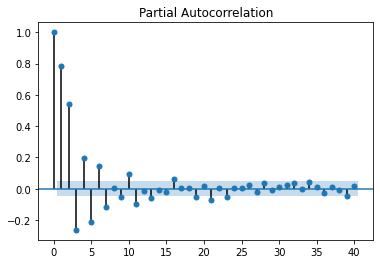

In [42]:
sm.graphics.tsa.plot_pacf(label_filtered, lags=40)
plt.show()

In [43]:
hmm3_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c', exog = df_test_exog, 
                               exog_tvtp = principalDf_test, switching_exog = True,switching_variance=True)
hmm3_test_results = hmm3_test.fit(start_params = hmm3_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [44]:
label_filtered = labeling(hmm3_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    1.290749
dtype: float64
0    1.485714
dtype: float64
0    1.980392
dtype: float64
0.37538340662051406 0.9105082796821855


## Two regimes, switching mean and variance with other dependent variables in mean.

In [45]:
hmm4 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c', exog = df_train_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_results = hmm4.fit(search_reps = 100)
print(hmm4_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 1821
Model:               MarkovRegression   Log Likelihood                9467.233
Date:                Sun, 06 Feb 2022   AIC                         -18914.465
Time:                        02:14:34   BIC                         -18859.394
Sample:                             0   HQIC                        -18894.148
                               - 1821                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016   6.03e-05     26.427      0.000       0.001       0.002
x1             0.0072      0.000     22.296      0.0

In [46]:
t1,t2 = Search_train(hmm4_results, duration_static, duration_bear)
print(t1,t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0.99 0.85


In [47]:
label_filtered = labeling(hmm4_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    24.627451
dtype: float64
0    2.525773
dtype: float64
0    5.015625
dtype: float64
0.9741441635200531 2.3852644177450952


In [48]:
hmm4_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c', exog = df_test_exog, 
                                switching_exog = True,switching_variance=True)
hmm4_test_results = hmm4_test.fit(start_params = hmm4_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [49]:
label_filtered = labeling(hmm4_test_results,t1,t2)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), label_test_logret(label_filtered))

0    19.115385
dtype: float64
0    1.258065
dtype: float64
0    6.538462
dtype: float64
0.37538340662051406 1.1992808237930972


In [50]:
hmm5 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c', exog = principalDf_train, 
                                switching_exog = True,switching_variance=True)
hmm5_results = hmm5.fit(search_reps = 100)
print(hmm5_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/

                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 1821
Model:               MarkovRegression   Log Likelihood                     nan
Date:                Sun, 06 Feb 2022   AIC                                nan
Time:                        02:14:58   BIC                                nan
Sample:                             0   HQIC                               nan
                               - 1821                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.6991        nan        nan        nan         nan         nan
x1           653.5169        nan        nan        n

This model labels the observables from a perspective fairly different from bear and bull concept.

## Method 1
## Pick thresholds such that the durations meet certain criteria

In [51]:
## some tech issue for this function

#from scipy.optimize import minimize
def FindTresholds(model_train):
  threshold1,threshold2 = 70,30
  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  duration_bear = duration(label)
  duration_bear_mean = duration_bear.mean()
    
  #find threshold1 such that the bear duration reach 4
  while(duration_bear_mean <=4 and threshold1 <=99):
    threshold1+=1
    label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
    duration_bear = duration(label)
    duration_bear_mean = duration_bear.mean()
    
  #find threshold2 that maximizes log return
  #logret_prev = label_logret(label_train_filtered)
  #for threshold2 in range(30,threshold1):
  #  label_train_filtered = labeling(model_train,threshold1/100, threshold2/100)
  #  logret = logret(label_train_filtered)
  #  if logret < logret_prev:
  #    threshold2-=1
  #    break
  #  logret_prev = logret

  return threshold1/100,threshold2/100


In [52]:
label_filtered = labeling(hmm1_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    30.26087
dtype: float64
0    2.493671
dtype: float64
0    5.295455
dtype: float64
0.9741441635200531 2.566789011962518


In [53]:
np.histogram(label_filtered)

(array([ 233,    0,    0,    0,    0,  197,    0,    0,    0, 1391]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [54]:
label_filtered = labeling(hmm1_test_results,0.99,0.89)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    20.56
dtype: float64
0    1.137931
dtype: float64
0    5.888889
dtype: float64
0.37538340662051406 1.2052761788110558


In [55]:
np.histogram(label_filtered)

(array([159,   0,   0,   0,   0,  33,   0,   0,   0, 513]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [56]:
label_filtered = labeling(hmm2_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    11.022727
dtype: float64
0    2.096296
dtype: float64
0    7.38961
dtype: float64
0.9741441635200531 2.5860591741208987


In [57]:
np.histogram(label_filtered)

(array([569,   0,   0,   0,   0, 283,   0,   0,   0, 969]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [58]:
label_filtered = labeling(hmm2_test_results,0.99, 0.45)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    5.647887
dtype: float64
0    1.487805
dtype: float64
0    8.714286
dtype: float64
0.37538340662051406 1.4388085962693486


In [59]:
np.histogram(label_filtered)

(array([183,   0,   0,   0,   0, 122,   0,   0,   0, 400]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [60]:
label_filtered = labeling(hmm3_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    7.25
dtype: float64
0    1.800971
dtype: float64
0    5.574468
dtype: float64
0.9741441635200531 2.409126031968682


In [61]:
np.histogram(label_filtered)

(array([ 262,    0,    0,    0,    0,  371,    0,    0,    0, 1188]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [62]:
label_filtered = labeling(hmm3_test_results,0.99, 0.71)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    2.477273
dtype: float64
0    1.143791
dtype: float64
0    2.065217
dtype: float64
0.37538340662051406 1.1636564058245893


In [63]:
np.histogram(label_filtered)

(array([ 95,   0,   0,   0,   0, 175,   0,   0,   0, 435]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [64]:
label_filtered = labeling(hmm4_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_train['log_ret'].sum(), label_train_logret(label_filtered))

0    23.527273
dtype: float64
0    2.325843
dtype: float64
0    5.015625
dtype: float64
0.9741441635200531 2.4007304660203324


In [65]:
np.histogram(label_filtered)

(array([ 321,    0,    0,    0,    0,  207,    0,    0,    0, 1293]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))

In [66]:
label_filtered = labeling(hmm4_test_results,0.99, 0.91)
print((duration(label_filtered))[0].mean())
print((duration(label_filtered))[1].mean())
print((duration(label_filtered))[2].mean())
print(df_test['log_ret'].sum(), (df_test['log_ret']*label_filtered).sum())

0    19.692308
dtype: float64
0    1.2
dtype: float64
0    6.538462
dtype: float64
0.37538340662051406 1.2209678826760253


In [67]:
np.histogram(label_filtered)

(array([170,   0,   0,   0,   0,  24,   0,   0,   0, 511]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))